In [4]:
import numpy as np
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from fastFM import als
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from matplotlib import pyplot as plt

In [3]:
def preProcessAdgroup(AdGroupFile):
    adGroup=pd.read_csv(AdGroupFile)
    adGroup.json=adGroup.json.map(lambda x:json.loads(x)['settings'][-1]["settingType"] if json.loads(x)['settings'] else "Not Clear")
    adGroup.to_csv("adGroup.csv")
    

#### All data: web 89347, mobile 23507
#### Ctr>0 data: web 50024, mobile 16672

In [90]:
def splitData(fileName):
    data=pd.read_csv(fileName)
    x_train, x_test, y_train, y_test = train_test_split(data, np.ones(data.shape[0]), test_size=0.2, random_state=33)
    
    print("--------------------------Adgroup Problem----------------------------")
    trainAdGroup=pd.unique(x_train["adGroup"])    
    testAdGroup=pd.unique(x_test["adGroup"])
    toRemoveAd=list(set(trainAdGroup).difference(set(testAdGroup)))
    print("Difference in train and test:", len(toRemoveAd))
    print(toRemoveAd)
    
    print("--------------------------placement problem---------------------------------")
    trainPlacement=pd.unique(x_train["placement"])    
    testPlacement=pd.unique(x_test["placement"])
    toRemovePla=list(set(trainPlacement).difference(set(testPlacement)))
    print(toRemovePla)
    print("Difference in train and test:", len(list(set(trainPlacement).difference(set(testPlacement)))))
    x_train=x_train[~x_train.adGroup.isin(toRemoveAd)]
    x_train=x_train[~x_train.placement.isin(toRemovePla)]
    
    x_train.to_csv("train.csv")
    x_test.to_csv("test.csv")

In [13]:
def loadData(filename,negativeRate):
    data=pd.read_csv(filename)
    c=data['Ctr'].apply(lambda x: 1 if x>0 else 0)
    print(c.value_counts())

    noneZeros=data[data["Ctr"] >0].shape[1]*negativeRate
    x = []
    y = []
    adGroupList = set()
    placementList = set()
    print("----------------------------------------Start parse---------------------------------------------")
    for row in data.iterrows():
        adGroupId, placement, settings,placementType ,target= row[1]["adGroup"], row[1]["placement"], row[1]['settings'],row[1]["placementType"],row[1]["target"]
        if target>0:
            x.append({"adGroup": str(adGroupId), "placement": str(placement),"settings":settings,"placementType":placementType})            
            y.append(float(target))
        elif target==0 and noneZeros>0:
            noneZeros-=1
            x.append({"adGroup": str(adGroupId), "placement": str(placement),"settings":settings,"placementType":placementType})
            y.append(float(target))
        adGroupList.add(adGroupId)
        placementList.add(placement)
    
    print("mean:",round(np.array(y).mean(),3))    
   
    print("end parse")
    return (x, np.array(y))

def build_anti_testset(X_train, fill=None):
        print("Building anti Train Dataset")
        anti_testset = []
        X_train=pd.DataFrame(X_train)
        adGroupList=pd.unique(X_train["adGroup"])
        placementList=pd.unique(X_train["placement"])
        anti_testset = []
        for adGroup in adGroupList:
            already=X_train.loc[X_train["adGroup"]==adGroup]["placement"]
            anti_testset += [{"adGroup": str(adGroup), "placement": str(placement)} for placement in placementList if placement not in already]
        return anti_testset

def to_csc(x):
    v = DictVectorizer()
    data = v.fit_transform(x)    
    x = sp.coo_matrix(data)
    x = sp.csc_matrix(x)
    return x

In [ ]:
def loadData(filename,negativeRate):
#     data=pd.read_csv(filename)
#     c=data['Ctr'].apply(lambda x: 1 if x>0 else 0)
    data = pd.read_csv("./dac/Adwords/AllFeatures2020.csv")
    sparse_features = ["BaseAdGroupId", "Criteria"]
    multivalue_features=['languageCode','locationName']
    data['Ctr']=data['Ctr'].apply(lambda x: 1 if x>0 else 0)
    
    # 2. Process dense features
    dense_features = ['adActiveViewCpm','adActiveViewCtr','adActiveViewImpressions','adActiveViewMeasurability','adActiveViewMeasurableCost',
                          'adActiveViewMeasurableImpressions','adActiveViewViewability','adAverageCpc','adImpressions','adCtr','plaActiveViewCpm','plaActiveViewCtr','plaActiveViewImpressions','plaActiveViewMeasurability','plaActiveViewMeasurableCost',
                          'plaActiveViewMeasurableImpressions','plaActiveViewViewability','plaAverageCpc','plaImpressions','plaCtr']
    
    result=data[sparse_features+dense_features]
    print("----------------------------------------Start parse---------------------------------------------")
    for row in data.iterrows():
        adGroupId, placement, settings,placementType ,target= row[1]["adGroup"], row[1]["placement"], row[1]['settings'],row[1]["placementType"],row[1]["target"]
        if target>0:
            x.append({"adGroup": str(adGroupId), "placement": str(placement),"settings":settings,"placementType":placementType})            
            y.append(float(target))
        elif target==0 and noneZeros>0:
            noneZeros-=1
            x.append({"adGroup": str(adGroupId), "placement": str(placement),"settings":settings,"placementType":placementType})
            y.append(float(target))

    
    print("mean:",round(np.array(y).mean(),3))    
   
    print("end parse")
    return (x, np.array(y))

In [3]:
def PrecisionRecall(x_test,pred,N):
    hit = 0
    n_recall = 1
    n_precision = 1
    adGroupList=pd.unique(x_test["adGroup"])
    pred[["adGroup"]] = pred[["adGroup"]].astype(int)
    print("N is {} ".format(N))
    print("Evaluating the model......")
    for adGroup in adGroupList:
        topN=pred.loc[pred["adGroup"]==adGroup].sort_values("target",ascending=False)[:N]
  
        groundTruth=x_test.loc[x_test["adGroup"]==adGroup]
        groundTruth=groundTruth[groundTruth["target"]>0]

        intersection = pd.merge(topN,
                 groundTruth,
                 how='inner', on=['adGroup','placement']
                 )
        hit += intersection.shape[0]
        n_recall += groundTruth.shape[0]
        n_precision += N
    print("Evaluation Finished!")
       
    return [hit / (1.0 * n_recall), hit / (1.0 * n_precision)]

In [8]:
def trainFM(n_iter,topN_low,topN_high):
    
    step_size = 1
    
#     print("Threshold of Placement: {}, Adgroup: {}".format(n_Placement,n_Adgroup))
    (X_train, y_train)=loadData("train.csv",2)
    originalAnti=build_anti_testset(X_train)
    X_train=to_csc(X_train)
    antiTrain=to_csc(originalAnti)
    print("testset records:", len(originalAnti))
    (X_test, y_test)=loadData("test.csv",3)
    X_test=to_csc(X_test)
    fm = als.FMRegression(n_iter=0, init_stdev=0.5, rank=6, l2_reg_w=10, l2_reg_V=20)
    print(type(X_train))
    fm.fit(X_train, y_train)
    
    
    rmse_train = []
    MSE_train=[]
    rmse_test = []
    MSE_test=[]
    for i in range(1, n_iter):
        fm.fit(X_train, y_train, n_more_iter=step_size)
        y_pred = fm.predict(X_test)
        rmse_train.append(np.sqrt(mean_squared_error(fm.predict(X_train), y_train)))
        rmse_test.append(np.sqrt(mean_squared_error(fm.predict(X_test), y_test)))
        MSE_train.append(mean_squared_error(fm.predict(X_train), y_train))
        MSE_test.append(mean_squared_error(fm.predict(X_test), y_test))
    x = np.arange(1, n_iter) * step_size

#     with plt.style.context('fivethirtyeight'):
#         plt.plot(x, MSE_train, label='train')
#         plt.plot(x, MSE_test, label='test')
#         plt.legend()
#         plt.show()
    plt.plot(x, MSE_train, label='train')
    plt.plot(x, MSE_test, label='test')
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
        

    

### Add Web or Mobile feature，Join Adgroup Settings, placement 50, adgroup 50, Ctr outlierRate 98%

----------------------------------------Start parse---------------------------------------------
mean: 0.397
end parse
Building anti Train Dataset
testset records: 1144704
----------------------------------------Start parse---------------------------------------------
mean: 0.4
end parse
<class 'scipy.sparse.csc.csc_matrix'>


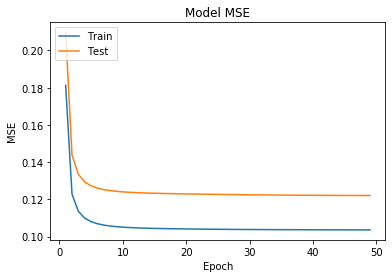

MSE: 0.122


In [9]:
#init_stdev=0.5

trainFM(50,100,500)

Threshold of Placement: 50, Adgroup: 50
----------------------------------------Start parse---------------------------------------------
mean: 0.397
end parse
Test dataset mean:  0.4
Predicted mean:  0.396


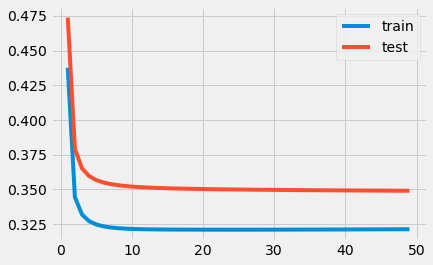

Threshold of Placement: 50, Adgroup: 50
----------------------------------------Start parse---------------------------------------------
mean: 0.397
end parse
Test dataset mean:  0.4
Predicted mean:  0.396


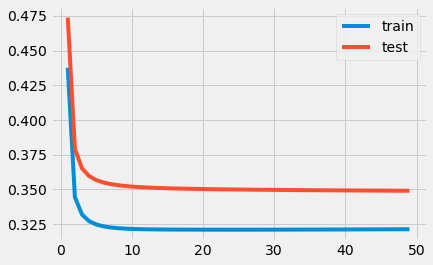

Threshold of Placement: 50, Adgroup: 50
----------------------------------------Start parse---------------------------------------------
mean: 0.397
end parse
Test dataset mean:  0.4
Predicted mean:  0.396


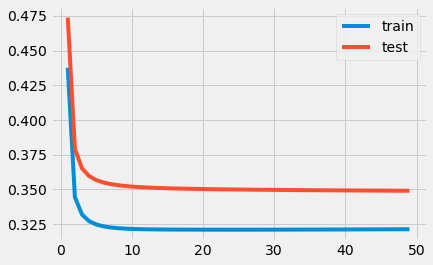

Threshold of Placement: 50, Adgroup: 50
----------------------------------------Start parse---------------------------------------------
mean: 0.397
end parse
Test dataset mean:  0.4
Predicted mean:  0.396


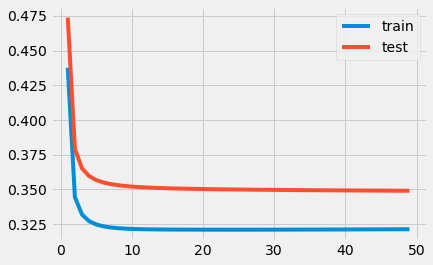

Threshold of Placement: 50, Adgroup: 50
----------------------------------------Start parse---------------------------------------------
mean: 0.397
end parse
Test dataset mean:  0.4
Predicted mean:  0.396


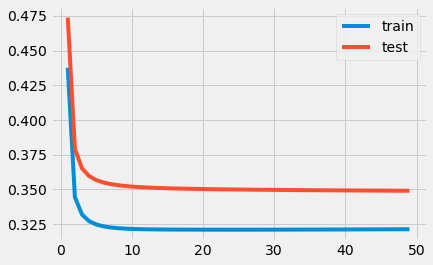

In [82]:
#init_stdev=0.5
for i in range(1,6):
    train(50,50,50,i,98)

### Add Web or Mobile feature, placement 50, adgroup 50, Ctr outlierRate 98%

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


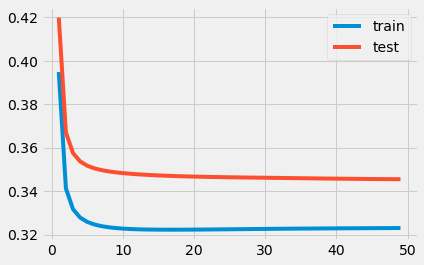

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


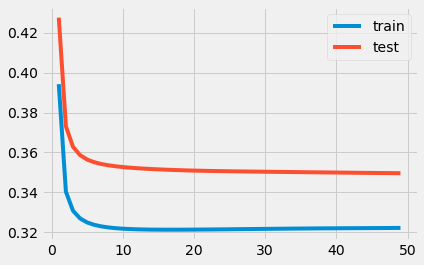

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


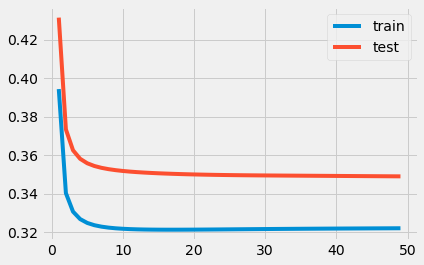

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


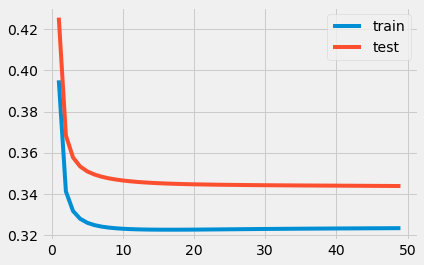

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


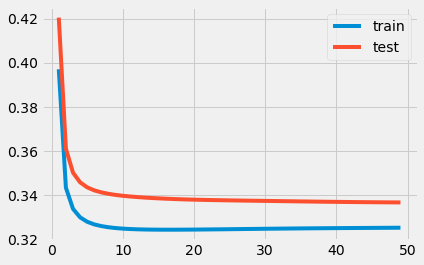

In [22]:
#init_stdev=0.5
for i in range(1,6):
    train(50,50,50,i,98)

### No Web or Mobile feature, placement 50, adgroup 50, Ctr outlierRate 98%

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


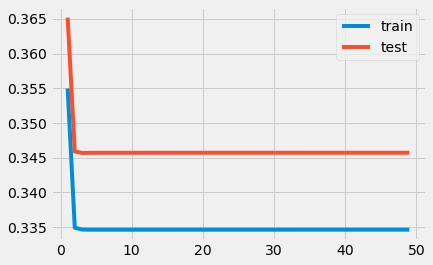

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


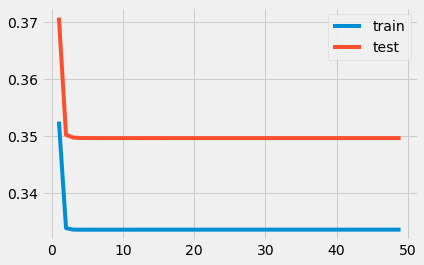

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


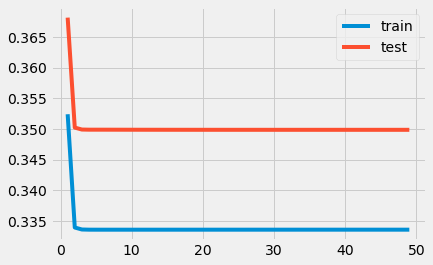

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


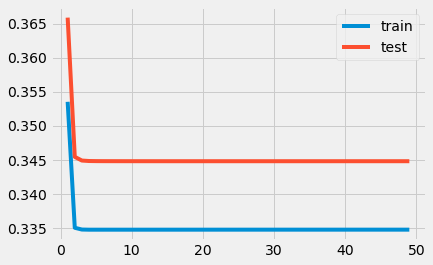

Threshold of Placement: 50, Adgroup: 50
Original with Impressions>100:271855 records
Outlier: [3.08]
Remove Ctr outliers:266414 records
Filter Adgroup with more than 50 Placement:207375 records
Filter placement displayed more than 50 Adgroup: 117715 records
start parse
web 0, mobile 0
mean: 0.397
end parse


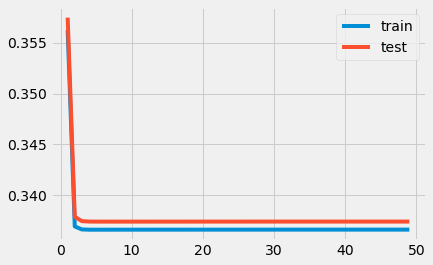

In [19]:
#init_stdev=0.5
for i in range(1,6):
    train(50,50,50,i,98)